# Time Series Forecast of the NBA 2018-19 Season

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.spatial.distance import cdist
from numpy.linalg import inv
from sklearn.kernel_ridge import KernelRidge
from bs4 import BeautifulSoup
from urllib.request import urlopen
from pandas.plotting import scatter_matrix
from IPython.display import display
import seaborn as sns
from sklearn.linear_model import LinearRegression
import pymc3 as pm
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
%matplotlib inline
from sklearn.metrics import mean_squared_error

In [4]:
"""
Obtaining box scores and advanced stats from every game over the past 3 seasons using
baskeballreference.com.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
"""
# rank each team in terms of defensive ability
def OpptoDRtg(i):
    url = 'https://www.basketball-reference.com/leagues/NBA_{}_ratings.html'.format(i)
    html = urlopen(url)
    soup = BeautifulSoup(html, 'html.parser')
    column_headers = [th.getText() for th in 
                soup.findAll('th',{'class':'poptip'})]
    
    column_headers.pop(0)
    data_rows = soup.findAll('tr')
    team_data = [[td.getText() for td in data_rows[i].findAll('td')]
        for i in range(len(data_rows))]
    tdf = pd.DataFrame(team_data, columns=column_headers)
    tdf = tdf.drop(['Conf', 'Div', 'W', 'L', 'W/L%', 'MOV', 'ORtg', 'NRtg', 'MOV/A', 'ORtg/A', 'DRtg/A', 
                    'NRtg/A'],axis=1)
    tdf = tdf.drop(tdf.index[[0,1]])
    tdf['DRtg'] = tdf['DRtg'].apply(pd.to_numeric, errors='coerce')
    arr = np.array(tdf['DRtg'])
    minDRtg = arr.min()
    diffDRtg = (arr.max() - arr.min())
    tdf.DRtg = (((tdf.DRtg - minDRtg) / diffDRtg) * 100) + 0.01
    tdf = tdf.replace(['Houston Rockets','Toronto Raptors','Golden State Warriors','Utah Jazz',
     'Philadelphia 76ers','Oklahoma City Thunder','Boston Celtics',
     'San Antonio Spurs','Portland Trail Blazers','Minnesota Timberwolves',
     'Denver Nuggets','New Orleans Pelicans','Indiana Pacers',
     'Cleveland Cavaliers','Washington Wizards','Miami Heat',
     'Los Angeles Clippers','Charlotte Hornets','Detroit Pistons',
     'Milwaukee Bucks','Los Angeles Lakers','Dallas Mavericks',
     'New York Knicks','Brooklyn Nets','Orlando Magic','Atlanta Hawks',
     'Memphis Grizzlies','Chicago Bulls','Sacramento Kings','Phoenix Suns'],         
      ['HOU', 'TOR','GSW', 'UTA','PHI', 'OKC', 'BOS', 'SAS', 'POR', 'MIN',
      'DEN', 'NOP', 'IND', 'CLE', 'WAS', 'MIA', 'LAC', 'CHO', 'DET', 'MIL', 'LAL',
      'DAL', 'NYK', 'BRK', 'ORL', 'ATL', 'MEM', 'CHI', 'SAC', 'PHO'])
    team_list = list(tdf.Team)
    drtg_list = list(tdf.DRtg)
    return team_list, drtg_list


# remove the players for loop, moving it to a different file
full_player_data = pd.DataFrame()
for i in range(2016,2019):
    url = 'https://www.basketball-reference.com/players/p/parkeja01/gamelog/{}'.format(i)
    html = urlopen(url)
    soup = BeautifulSoup(html, 'html.parser')
    column_headers = [th.getText() for th in 
            soup.findAll('th',{'class':'poptip'})]

    data_rows = soup.findAll('tr', {'id':['pgl_basic.{}'.format(x) for x in range (2000)]})
    player_data =[[td.getText() for td in data_rows[i].findAll('td')]
        for i in range(len(data_rows))]



    column_headers.pop(0)
    # print(column_headers)
    df = pd.DataFrame(player_data, columns=column_headers)
    df = df.drop(['Tm', '\xa0','\xa0'],axis=1)
    df = df[:].fillna(0)
    df['MP'] = df['MP'].str[:-3]
    df['Age'] = df['Age'].str[:2]
    df['Date'] = df['Date'].str[:4]
    df.columns = df.columns.str.replace('%', '_Perc')
    opp_list, drtg_list = OpptoDRtg(i)
    df = df.replace(opp_list,drtg_list)
    df['Opp'] = df['Opp'].apply(pd.to_numeric, errors='coerce')
    df['Opp'] = df['Opp'].round(2)
    full_player_data = full_player_data.append(df, ignore_index=True)
    
    
display(full_player_data.head())

,G,Date,Age,Opp,GS,MP,FG,FGA,FG_Perc,3P,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-
0,1,2015,20,82.50,1,16,1,5,.200,0,...,3,3,1,0,0,0,0,2,0.5,-8
1,2,2015,20,69.12,1,17,3,6,.500,0,...,1,1,1,0,0,1,1,6,2.6,+10
2,3,2015,20,93.78,1,24,4,7,.571,0,...,2,2,0,0,0,1,0,8,3.9,+1
3,4,2015,20,35.42,1,23,4,6,.667,0,...,5,8,1,2,0,0,1,8,11.3,+23
4,5,2015,20,44.91,1,30,5,10,.500,0,...,3,3,1,0,0,1,2,12,6.8,-1


In [125]:
## playerDF contains dataframes of players in the 2014 draft

#appliying linear regression to draft class 2014 to predict first 20 games of 2018-19 season
#playerDF


# sns.lineplot(data=train.reset_index(), x='index',y='PTS')

# for i in range(len(playerDF)):
#     plt.figure(i)
#     x = playerDF[i].shape[0]
#     x = x - 1
#     playerDF[i] = playerDF[i]['PTS']
#     train = playerDF[i].loc['0':'x-1']
#     train = train.apply(pd.to_numeric,errors='coerce')
#     sns.lineplot(data=train.reset_index(), x='index', y='PTS')

(158, 26) (158, 12)


,G,Date,Age,Opp,GS,MP,FG,FGA,FG_Perc,3P,...,ORB_Perc,DRB_Perc,TRB_Perc,AST_Perc,STL_Perc,BLK_Perc,TOV_Perc,USG_Perc,ORtg,DRtg
0,1,2015,20,82.50,1,16,1,5,.200,0,...,0.0,22.0,10.1,9.2,0.0,0.0,0.0,14.2,51,97
1,2,2015,20,69.12,1,17,3,6,.500,0,...,0.0,6.5,3.3,10.2,0.0,0.0,14.3,18.1,91,110
2,3,2015,20,93.78,1,24,4,7,.571,0,...,0.0,8.3,4.3,0.0,0.0,0.0,11.8,16.1,86,102
3,4,2015,20,35.42,1,23,4,6,.667,0,...,15.3,22.2,19.0,9.3,4.6,0.0,0.0,12.2,149,103
4,5,2015,20,44.91,1,30,5,10,.500,0,...,0.0,11.6,5.5,5.8,0.0,0.0,8.4,18.6,108,105


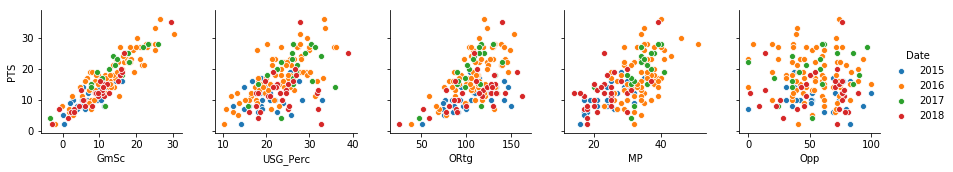

In [5]:
## needs to be changed  - currently incorrect for 2014 draft class
full_player_data_adv = pd.DataFrame()
for i in range(2016,2019):
    url_adv = 'https://www.basketball-reference.com/players/p/parkeja01/gamelog-advanced/{}/'.format(i)
    html_adv = urlopen(url_adv)
    soup_adv = BeautifulSoup(html_adv, 'html.parser')
    column_headers = [th.getText() for th in 
                            soup_adv.findAll('th',{'class' :'poptip'})]
    data_rows = soup_adv.findAll('tr', {'id':['pgl_advanced.{}'.format(x) for x in range(772)]})
    player_data = [[td.getText() for td in data_rows[i].findAll('td')] for i in range(len(data_rows))]


    column_headers.pop(0)
    df_adv = pd.DataFrame(player_data,columns=column_headers)
    df_adv.columns = df_adv.columns.str.replace('%', '_Perc')
    df_adv = df_adv.drop(['Opp','Tm','\xa0', '\xa0', 'G', 'MP', 'GmSc', 'GS', 'Date', 'Age'],axis=1)
    full_player_data_adv = full_player_data_adv.append(df_adv, ignore_index=True)

final_player_data = pd.concat([full_player_data,full_player_data_adv],axis=1)


test_cols = ['MP','PTS','FG_Perc','GmSc','+/-', 'Date','FG','USG_Perc', 'ORtg','G','Opp']
test = final_player_data[test_cols].apply(pd.to_numeric, errors='coerce')
sns_plot = sns.pairplot(test,hue='Date', x_vars = ['GmSc', 'USG_Perc', 'ORtg', 'MP','Opp'], y_vars =['PTS'])
sns_plot.savefig("output.png")

print(full_player_data.shape, full_player_data_adv.shape)

display(final_player_data.head())

In [6]:
"""
Feature Selection Methods 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

subset selection: greedy method - least squared for certain number of features
    best first error
    pick a feature which minimises sqer
    pick next feature which minimises least square errors
    
    change the features such that it uses FG from previous games and, not from the game it
    is trying to find the points for - IMPORTANT!!
    
    SelectKBest explanation
    
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
be careful about train error and test error.

PCA - select first eigenvectors
it is an unsupervised method - probably useless, use subset selection!
"""
from sklearn.feature_selection import SelectKBest, chi2

def featureSel():
    pass


features = ['MP','FG_Perc','GmSc', 'Date','FGA','USG_Perc', 'ORtg','Opp']
response = final_player_data.PTS.apply(pd.to_numeric,errors='coerce')
features_num = final_player_data[features].apply(pd.to_numeric, errors='coerce')
features_num.fillna(0, inplace=True)
features_num['GmSc'] = features_num['GmSc'].clip_lower(0)

#attempt at SelectKBest
display(features_num.head())
X_feat = np.array(features_num)
y_resp = np.array(response)

X_new = SelectKBest(chi2, k=4).fit_transform(X_feat, y_resp)
X_new.shape

,MP,FG_Perc,GmSc,Date,FGA,USG_Perc,ORtg,Opp
0,16,0.200,0.5,2015,5,14.2,51,82.50
1,17,0.500,2.6,2015,6,18.1,91,69.12
2,24,0.571,3.9,2015,7,16.1,86,93.78
3,23,0.667,11.3,2015,6,12.2,149,35.42
4,30,0.500,6.8,2015,10,18.6,108,44.91


(158, 4)

In [7]:
"""
Linear Regression: sklearn Implementation -
NOTE: Currently naive implementation - no time series involved!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
add a difficulty scaling for a team
add game importance factor


analysis, error:

>> squared error to compare with the actual score
   shuffle data, its a time series - cut training in half

>> 'weighting of importance' variable. weighted least of squares
    prepare the weighting - for least sqaures, add a weighting to
    the least squares.
    
>>  Beef it up: compare different feature methods, PCA w/ first x features - 
    same with subset selection - show that initially tthe error goes down, but then 
    goes back up due to overfitting!
    
>> importance weighting for certain games being played, such as games close tothe playoffs?

"""
from sklearn.model_selection import train_test_split 
feature_cols =['GmSc','USG_Perc', 'ORtg']
X = final_player_data[feature_cols]
y = final_player_data.PTS
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
clf = LinearRegression()

def train_and_predict(clf, X_train, y_train,X_test):
    clf.fit(X_train, y_train)
    target = clf.predict(X_test).astype(int)
    return target


def meanSqEr(A, B):
    return np.square(A-B)


t = train_and_predict(clf, X_train, y_train, X_test)    
y_test = np.array(y_test).astype(int)

print(y_test)
print(t)

print(meanSqEr(t,y_test))


[10  8 15 17 12 18 21 18 24 12 12 12 10 14 28 10]
[11 10 15 16 14 18 25 15 22 13  9 13 13 16 29 13]
[ 1  4  0  1  4  0 16  9  4  1  9  1  9  4  1  9]


In [8]:
"""
Linear Regression: TensorFlow Implementation
NOTE: Currently naive implementation - no time series involved!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
"""
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
display(X.head())

X_train = np.array(X_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
y_train = y_train.values.reshape(-1,1)


#5 features, 222 data points
m_examples, n_features = X_train.shape


X_in = tf.placeholder(tf.float32, [m_examples, n_features], "X_in")
y_in = tf.placeholder(tf.float32, [m_examples, 1], "y_in")


w = tf.Variable(tf.random_normal((n_features, 1)), name="w")
b = tf.Variable(tf.constant(0.1, shape=[]), name="b")
h = tf.add(tf.matmul(X_in, w), b, name="h")

loss_op = tf.reduce_mean(tf.square(tf.subtract(y_in, h)), name="loss")
train_op = tf.train.GradientDescentOptimizer(0.00005).minimize(loss_op)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(1000):
        sess.run(train_op, feed_dict={
          X_in: X_train, 
          y_in: y_train
        })
    w_computed = sess.run(w)
    b_computed = sess.run(b)
    
#print(w_computed, b_computed)

#not sure that this is implemented correctly
#print(X_data.shape)
y_test = (np.matmul(X_test,w_computed) + b_computed)
print("Forecast PPG: {}".format(np.mean(y_test)))



,GmSc,USG_Perc,ORtg
0,0.5,14.2,51
1,2.6,18.1,91
2,3.9,16.1,86
3,11.3,12.2,149
4,6.8,18.6,108


Forecast PPG: 13.30075454711914


In [9]:
"""
Bayesian Linear Regression
~~~~~~~~~~~~~~~~~~~~~~~~~~
Check the theory is implemented correctly. There is a reasonably large
variance in PPG produced, ranging from high 10s to low 40s (for Anthony Davis).
Variance decreased when tuning the Beta parameter!

NOTE: Add noise (E) to the training data
NOTE:Currently naive implementation - no time series involved!

"""
from numpy.linalg import inv

X, X_test, y, y_test = train_test_split(X, y, test_size = 0.05)
X = np.array(X).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
y = np.array(y).astype(np.float32)
y = y.flatten()
# 5 features, >200 examples
m_examples, n_features = X.shape

#prior
sigmaPrior = 0.2 * np.eye(3)
muPrior = np.zeros(3)

#precision variables
B = 0.5

#Compute mean and covariance of the posterior
sigmaPost = inv(inv(sigmaPrior) + B * (np.matmul(X.T,X)))
muPost = np.matmul(sigmaPost,np.matmul((inv(sigmaPrior)),muPrior)+ B * np.matmul(X.T,y))
gaussPost = multivariate_normal(muPost, sigmaPost)

#sample = np.random.multivariate_normal(muPost, sigmaPost,1)
#Compute predictive posterior
muPred = np.dot(muPost,X_test.T)
sigmaPred = (1/B) + np.dot(X_test,np.dot(sigmaPost,X_test.T))
sample = np.random.multivariate_normal(muPred, sigmaPred, 1)

print("Forecast PPG: {}".format(np.mean(sample)))

Forecast PPG: 14.155367516500078


[[ 12.07512937]]


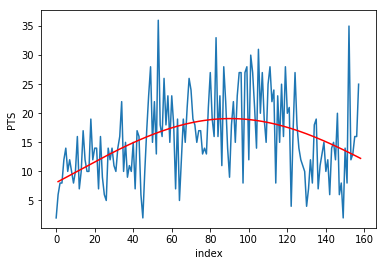

In [10]:
"""
Non-linear / Kernel Ridge Regression
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Using one feature (Games played) to predict the average PPG for the next 
season. Potentially add uncertainty / use Bayesian Regression to obtain a
probability distribution rather that point estimates.
"""
#sns.pairplot(test.reset_index(), x_vars = ['index'], y_vars = ['PTS'], height=9,kind='reg')
sns.lineplot(data=test.reset_index(), x='index', y='PTS')
krr_cols = ['PTS']
ppg = final_player_data[krr_cols].apply(pd.to_numeric, errors='coerce')
pointsPG = np.array(ppg).flatten()

gamesPlayed = np.arange(1,ppg.shape[0]+1)
pointsPG = pointsPG.reshape(-1,1)
gamesPlayed = gamesPlayed.reshape(-1,1)
krr = KernelRidge(alpha=0.5, kernel='rbf', gamma=0.00005, degree=3, coef0=1, kernel_params=None)
krr.fit(gamesPlayed, pointsPG)
y_krr = krr.predict(gamesPlayed)
plt.plot(gamesPlayed, y_krr,'r')

x = (gamesPlayed.item(-1) + 1)
print(krr.predict(x))
# for i in range(82):
#     p = krr.predict(i)
#     prediction.append(p)

# print("Forecast PPG: {}".format(np.mean(prediction)))

In [11]:
# #using bins instead

# bins = np.array_split(pointsPG, 23)
# mean_of_bins = []
# for a_bin in bins:
#     x = np.mean(a_bin)
#     mean_of_bins.append(x)
# x_axis = np.arange(1, len(mean_of_bins)+1)
# sns.scatterplot(np.array(x_axis), np.array(mean_of_bins))

In [12]:
"""
Time Series Linear Regression
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Forecasting player points-per-game (PPG) for
the 2018-19 game by game

methods:

>> naive method
>> simple average
>> moving average
>> weighted moving average - more recent data points have more importance!
>> simple exponential smoothing w/ alpha smoothing parameter
>> """

sns.set(rc={'figure.figsize':(11.7,8.27)})

player_data_2019 = pd.DataFrame()
url = 'https://www.basketball-reference.com/players/p/parkeja01/gamelog/2019'
html = urlopen(url)
soup = BeautifulSoup(html, 'html.parser')
column_headers = [th.getText() for th in 
        soup.findAll('th',{'class':'poptip'})]

data_rows = soup.findAll('tr', {'id':['pgl_basic.{}'.format(x) for x in range (249)]})
player_data =[[td.getText() for td in data_rows[i].findAll('td')]
    for i in range(len(data_rows))]

column_headers.pop(0)
# print(column_headers)
df = pd.DataFrame(player_data, columns=column_headers)
df = df.drop(['Tm', '\xa0','\xa0'],axis=1)
df = df[:].fillna(0)
df['MP'] = df['MP'].str[:-3]
df['Age'] = df['Age'].str[:2]
df['Date'] = df['Date'].str[:4]
df.columns = df.columns.str.replace('%', '_Perc')
opp_list, drtg_list = OpptoDRtg(2019)
df = df.replace(opp_list,drtg_list)
df['Opp'] = df['Opp'].apply(pd.to_numeric, errors='coerce')
df['Opp'] = df['Opp'].round(2)
player_data_2019 = player_data_2019.append(df, ignore_index=True)
display(player_data_2019.head())


HTTPError: HTTP Error 500: Internal Server Error

In [106]:
ppg = final_player_data[krr_cols].apply(pd.to_numeric, errors='coerce')

#pointsPG = np.array(ppg).flatten()
#gamesPlayed = np.arange(1,ppg.shape[0]+1)
#sns.lineplot(gamesPlayed, pointsPG)
#display(ppg)
#sns.lineplot(data=ppg.reset_index(),x='index', y='PTS')

#append test data to the end of the dataframe
ppg_test = player_data_2019[krr_cols].apply(pd.to_numeric, errors='coerce')
#sns.lineplot(data=ppg_test.reset_index(),x='index', y='PTS')
ppg = ppg.append(ppg_test, ignore_index=True)

#remove values which are 0!

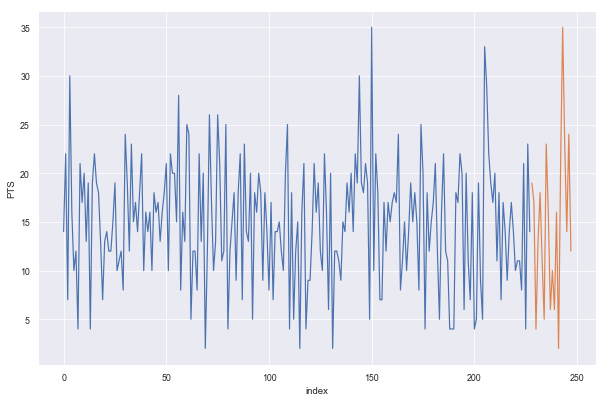

In [101]:
# print(ppg.to_string())

#splitting ppg dataframe into training and validation
sns.set(rc={'figure.figsize':(10,6.5)})
sns.set_context('paper')

ppg = ppg[ppg.PTS != 0]
#print(ppg.to_string())

train = ppg.loc['0':'227']
valid = ppg.loc['228':'247']

sns.lineplot(data=train.reset_index(), x='index', y='PTS')
sns.lineplot(data=valid.reset_index(), x = 'index', y='PTS')

#print(train)


8.040522371090077

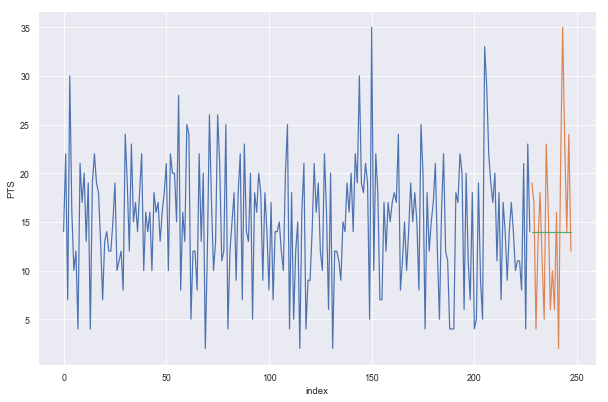

In [102]:
#naive approach - take the last value of training data, and extrapolate
# this is a poor approach for predicting points per game for a player
d = np.asarray(train.PTS)
y_hat = valid.copy()
y_hat['PTS']=d[len(d)-1]
sns.lineplot(data=train.reset_index(), x='index', y='PTS')
sns.lineplot(data=valid.reset_index(), x = 'index', y='PTS')
sns.lineplot(data=y_hat['PTS'].reset_index(), x='index', y='PTS') #fix y-axis label


# calculate the rmse for naive approach!
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(valid.PTS, y_hat.PTS))
rmse

10.327148686835104

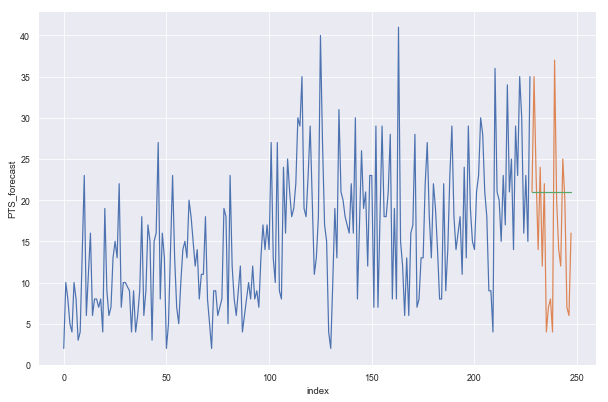

In [16]:
#simple moving average of a 20 games:
y_hat_avg = valid.copy()
y_hat_avg['PTS_forecast'] = train['PTS'].rolling(20).mean().loc[len(d)-1]

sns.lineplot(data=train.reset_index(), x='index', y='PTS')
sns.lineplot(data=valid.reset_index(), x = 'index', y='PTS')
sns.lineplot(data=y_hat_avg['PTS_forecast'].reset_index(), x='index', y='PTS_forecast') #fix y-axis label

rmse = sqrt(mean_squared_error(valid.PTS, y_hat_avg.PTS_forecast))
rmse


9.320140412088117

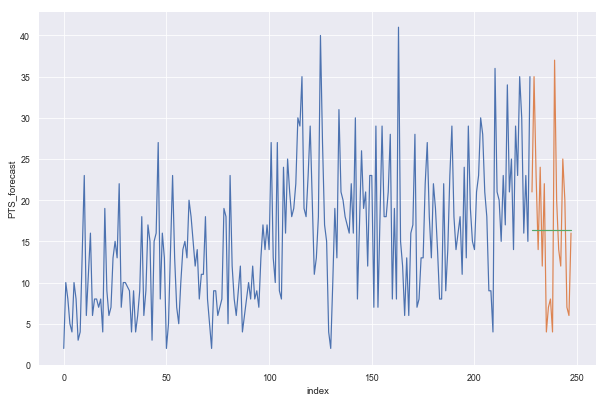

In [17]:
y_hat_avg = valid.copy()
y_hat_avg['PTS_forecast'] = train['PTS'].rolling(170).mean().loc[len(d)-1]

sns.lineplot(data=train.reset_index(), x='index', y='PTS')
sns.lineplot(data=valid.reset_index(), x = 'index', y='PTS')
sns.lineplot(data=y_hat_avg['PTS_forecast'].reset_index(), x='index', y='PTS_forecast') #fix y-axis label

rmse = sqrt(mean_squared_error(valid.PTS, y_hat_avg.PTS_forecast))
rmse


     PTS        SES
228   21  17.254051
229   35  17.254051
230   23  17.254051
231   14  17.254051
232   24  17.254051
233   12  17.254051
234   22  17.254051
235    4  17.254051
236    7  17.254051
237    8  17.254051
238    4  17.254051
239   37  17.254051
240   20  17.254051
241   14  17.254051
242   12  17.254051
243   25  17.254051
244   20  17.254051
245    7  17.254051
246    6  17.254051
247   16  17.254051


9.345757713400948

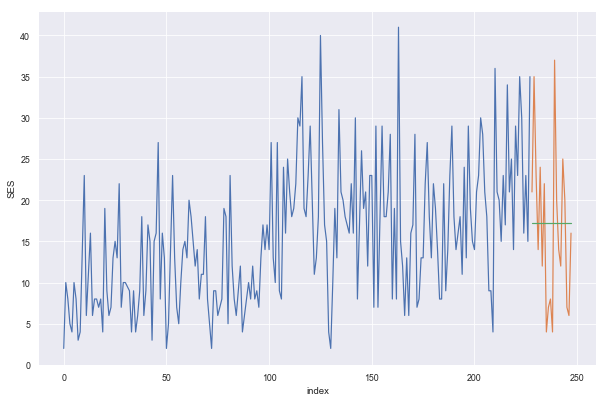

In [19]:
#simple exponential smoothing
from statsmodels.tsa.api import ExponentialSmoothing,SimpleExpSmoothing, Holt

y_hat = valid.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['PTS'])).fit(smoothing_level=0.013,optimized=False)

y_hat['SES'] = fit2.forecast(len(valid))
sns.lineplot(data=train.reset_index(), x='index', y='PTS')
sns.lineplot(data=valid.reset_index(), x = 'index', y='PTS')
sns.lineplot(data=y_hat['SES'].reset_index(), x='index', y='SES') #fix y-axis label

print(y_hat)

rmse = sqrt(mean_squared_error(valid.PTS, y_hat.SES))
rmse

In [37]:
"""plt.style.use('default')
plt.figure(figsize=(16,8))
import statsmodels.api as sm
sm.tsa.seasonal_decompose(train.PTS).plot()
result = sm.tsa.stattools.asfuller(train.PTS)
plt.show()"""
print(5)

5


     PTS    HoltLin
228   21  22.055511
229   35  22.114548
230   23  22.173584
231   14  22.232620
232   24  22.291657
233   12  22.350693
234   22  22.409730
235    4  22.468766
236    7  22.527803
237    8  22.586839
238    4  22.645876
239   37  22.704912
240   20  22.763948
241   14  22.822985
242   12  22.882021
243   25  22.941058
244   20  23.000094
245    7  23.059131
246    6  23.118167
247   16  23.177203


11.208067341564039

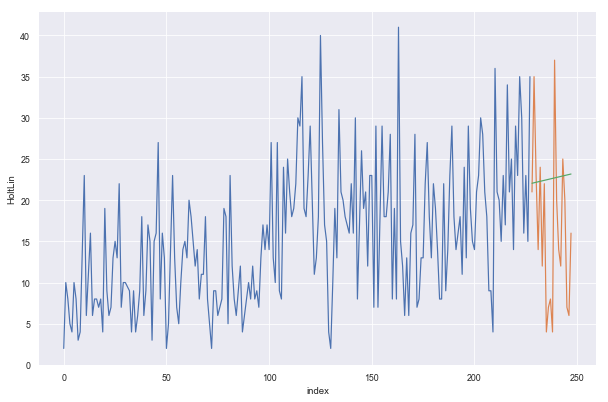

In [20]:
y_hat_holt = valid.copy()
fit1 = Holt(np.asarray(train['PTS'])).fit(smoothing_level=0.015,smoothing_slope=0.01)
y_hat_holt['HoltLin'] = fit1.forecast(len(valid))

sns.lineplot(data=train.reset_index(), x='index', y='PTS')
sns.lineplot(data=valid.reset_index(), x = 'index', y='PTS')
sns.lineplot(data=y_hat_holt['HoltLin'].reset_index(), x='index', y='HoltLin') #fix y-axis label

print(y_hat_holt)

rmse = sqrt(mean_squared_error(valid.PTS, y_hat_holt.HoltLin))
rmse

     PTS   HoltWint
228   21  20.444160
229   35  20.371072
230   23  23.047869
231   14  20.974603
232   24  20.651389
233   12  22.078170
234   22  18.504936
235    4  25.431054
236    7  18.858150
237    8  19.284833
238    4  22.961601
239   37  20.888025
240   20  18.815143
241   14  20.992204
242   12  21.669389
243   25  23.595966
244   20  16.023300
245    7  23.700041
246    6  22.127064
247   16  22.803389


11.138196341208092

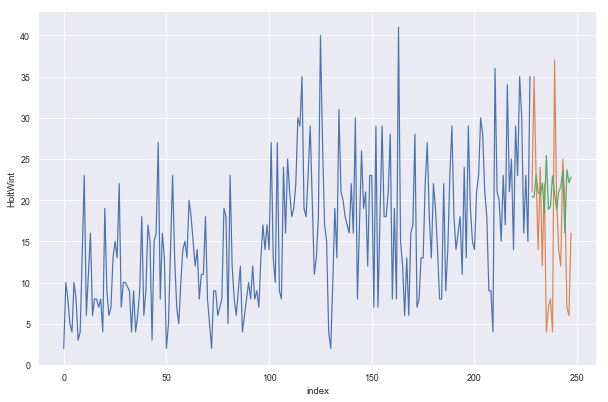

In [21]:
y_hat_avg = valid.copy()
fit1 = ExponentialSmoothing(np.asarray(train['PTS']), seasonal_periods=50, seasonal='add').fit()
y_hat_avg['HoltWint'] =fit1.forecast(len(valid))

sns.lineplot(data=train.reset_index(), x='index', y='PTS')
sns.lineplot(data=valid.reset_index(), x = 'index', y='PTS')
sns.lineplot(data=y_hat_avg['HoltWint'].reset_index(), x='index', y='HoltWint') #fix y-axis label

print(y_hat_avg)

rmse = sqrt(mean_squared_error(valid.PTS, y_hat_avg.HoltWint))
rmse

In [ ]:
# for i in range(len(playerDF)):
#     plt.figure(i)
#     jokic = playerDF[i]
#     jokic = jokic.apply(pd.to_numeric, errors='coerce')
#     jokic = jokic[jokic.PTS != 0]

#     jokic = jokic['PTS']
#     jokic = jokic.reset_index()

#     jokic_arr = np.array(jokic.PTS)
#     gamesPl = len(jokic_arr) + 1
#     game = np.arange(1,gamesPl)

#     #test data
#     jokic2019 = player2019DF[i].apply(pd.to_numeric, errors ='coerce')
#     jokic2019 = jokic2019[jokic2019.PTS != 0]
#     jokic2019 = jokic2019['PTS']
#     jokic2019 = jokic2019.reset_index()
#     jokic2019_arr = np.array(jokic2019.PTS)


#     gamesPl_tst = len(jokic2019_arr) + 1
#     game_tst = np.arange(gamesPl, gamesPl + gamesPl_tst-1)

#     total = np.append(jokic_arr,jokic2019_arr)
#     train = total[:gamesPl-1]
#     valid = total[gamesPl-1:]

#     games_tot = np.append(game,game_tst)
#     games_tot
#     gtrain = games_tot[:gamesPl-1]
#     gvalid = games_tot[gamesPl-1:]

#     plt.plot(gtrain,train)
#     plt.plot(gvalid,valid)
#     gtrain = gtrain.reshape(-1,1)
#     gvalid = gvalid.reshape(-1,1)
#     train = train.reshape(-1,1)
#     train_classifier(clf, gtrain, train)
#     p = train_and_predict(clf, gtrain,train,gvalid)

#     #calculate rmse for prediction vs result
#     rmse = sqrt(mean_squared_error(p, valid))
#     print("Linear Regression: player {0} rmse error is: {1}".format(players[i],rmse))

In [ ]:
#ARIMA

In [ ]:
#vector auto regression